In [191]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as disp
import folium
import time
from scipy.stats import norm, gamma, f, chi2

In [179]:
sns.set_style('darkgrid')

In [312]:
ee.Authenticate()


Successfully saved authorization token.


In [313]:
ee.Initialize()

In [314]:
dfo_floods = ee.ImageCollection("GLOBAL_FLOOD_DB/MODIS_EVENTS/V1")
dfo_floods = dfo_floods.select(['flooded', 'jrc_perm_water'])


In [315]:
def createTimeBand(img):
    year = ee.Date(img.get('system:time_start')).get('year').subtract(1991)
    mask = img.select('flooded').gt(0).And(img.select('jrc_perm_water').eq(0))
    return ee.Image(year).byte().addBands(img.updateMask(mask)).select(['constant', 'flooded'])

In [316]:
# dfo_flooded = dfo_floods.map(createTimeBand)
dfo_flooded_2018 = dfo_floods.filterDate(ee.Date('2018-01-01'), ee.Date('2018-12-31')).map(createTimeBand)

In [317]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data © <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)
 

folium.Map.add_ee_layer = add_ee_layer

In [318]:
dfo_flooded_2018.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'id': 'GLOBAL_FLOOD_DB/MODIS_EVENTS/V1',
 'version': 1641990150503727,
 'properties': {'date_range': [950745600000, 1544400000000],
  'period': 0,
  'type_name': 'ImageCollection',
  'max_mirrored_version': 1627592385154748,
  'keywords': ['c2s',
   'cloudtostreet',
   'dartmouth',
   'dfo',
   'flood',
   'gfd',
   'inundation',
   'surface',
   'water'],
  'thumb': 'https://mw1.google.com/ges/dd/images/GLOBAL_FLOOD_DB_MODIS_EVENTS_V1_0_thumb.png',
  'description': '<p>The Global Flood Database contains maps of the extent and\ntemporal distribution of 913 flood events occurring between 2000-2018. For more\ninformation, see\n<a href="https://doi.org/10.1038/s41586-021-03695-w">the associated journal article</a>.</p><p>Flood events were collected from\nthe <a href="https://floodobservatory.colorado.edu/">Dartmouth Flood Observatory</a>\nand used to collect MODIS imagery. The selected\n913 events are those that were successfully mapped (passed q

In [319]:
flood_map = folium.Map(location = [17.832336,56.627625], zoom_start = 4.5, tiles = 'OpenStreetMap')
flood = dfo_flooded_2018.reduce(ee.Reducer.max())
# flood = dfo_flooded_2018.first()
flood_map.add_ee_layer(flood, vis_params=None, name='floods_2018')
display(flood_map)

In [320]:
flood.getInfo()

{'type': 'Image',
 'bands': [{'id': 'constant_max',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'flooded_max',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Define a location that looks interesting, and try to plot multiple data sources over it.

In [321]:
nigeria_loc = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              9.30816650390625,
              7.9640375200936235
            ],
            [
              10.1458740234375,
              7.9640375200936235
            ],
            [
              10.1458740234375,
              8.496820982890759
            ],
            [
              9.30816650390625,
              8.496820982890759
            ],
            [
              9.30816650390625,
              7.9640375200936235
            ]
          ]
        ]
      }
    }
  ]
}

coords = nigeria_loc['features'][0]['geometry']['coordinates']
nigeria_aoi = ee.Geometry.Polygon(coords)

Let's find a date during 2018 where we know flooding occurred in the area of interest above, and then collect other data to map around it.

In [322]:
dfo_floods_select = (ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')
                     .filterBounds(nigeria_aoi)
                     .filterDate(ee.Date('2018-01-01'), ee.Date('2018-12-31'))
                     # .filter(ee.Filter.gt('flooded', 0))
                     # .filter(ee.Filter.eq('jrc_perm_water', 0))
                     # .sort('system:time_start')
                  )

In [323]:
began = dfo_floods_select.aggregate_array('began').getInfo()
ended = dfo_floods_select.aggregate_array('ended').getInfo()

flood_dates = list(zip(began,ended))
flood_dates

[('2018-08-20', '2018-10-02')]

In [324]:
sentinel_1_fl = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(nigeria_aoi)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-10-31'))
)

sentinel_1_db = (ee.ImageCollection('COPERNICUS/S1_GRD')
                .filterBounds(nigeria_aoi)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-10-31'))
)

sentinel_2 = (ee.ImageCollection('COPERNICUS/S2')
                .filterBounds(nigeria_aoi)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-10-31'))
)

In [325]:
s1_times = sentinel_1_fl.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(t/1000)) for t in s1_times]

['08/01/18',
 '08/01/18',
 '08/06/18',
 '08/13/18',
 '08/13/18',
 '08/18/18',
 '08/25/18',
 '08/25/18',
 '08/30/18',
 '09/06/18',
 '09/06/18',
 '09/11/18',
 '09/18/18',
 '09/18/18',
 '09/23/18',
 '09/30/18',
 '09/30/18',
 '10/05/18',
 '10/12/18',
 '10/12/18',
 '10/17/18',
 '10/24/18',
 '10/24/18',
 '10/29/18']

In [326]:
s2_times = sentinel_2.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(t/1000)) for t in s2_times]

['08/03/18',
 '08/03/18',
 '08/03/18',
 '08/03/18',
 '08/08/18',
 '08/08/18',
 '08/08/18',
 '08/08/18',
 '08/13/18',
 '08/13/18',
 '08/13/18',
 '08/13/18',
 '08/18/18',
 '08/18/18',
 '08/18/18',
 '08/18/18',
 '08/23/18',
 '08/23/18',
 '08/23/18',
 '08/23/18',
 '08/28/18',
 '08/28/18',
 '08/28/18',
 '08/28/18',
 '09/02/18',
 '09/02/18',
 '09/02/18',
 '09/02/18',
 '09/07/18',
 '09/07/18',
 '09/07/18',
 '09/07/18',
 '09/12/18',
 '09/12/18',
 '09/12/18',
 '09/12/18',
 '09/22/18',
 '09/22/18',
 '09/22/18',
 '09/22/18',
 '09/27/18',
 '09/27/18',
 '09/27/18',
 '09/27/18',
 '10/02/18',
 '10/02/18',
 '10/02/18',
 '10/02/18',
 '10/07/18',
 '10/07/18',
 '10/07/18',
 '10/07/18',
 '10/12/18',
 '10/12/18',
 '10/12/18',
 '10/12/18',
 '10/17/18',
 '10/17/18',
 '10/17/18',
 '10/17/18',
 '10/22/18',
 '10/22/18',
 '10/22/18',
 '10/22/18',
 '10/27/18',
 '10/27/18',
 '10/27/18',
 '10/27/18']

In [327]:
sentinel_2.first().clip(nigeria_aoi).bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12',
 'QA10',
 'QA20',
 'QA60']

# Detecting changes in Sentinel-1 over study area

## Part I: Investigating distribution of pixel values

Select first image in Sentinel-1 collections to investigate

In [328]:
im_db = ee.Image(sentinel_1_db.first().clip(nigeria_aoi))
im_fl = ee.Image(sentinel_1_fl.first().clip(nigeria_aoi))

In [329]:
im_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [330]:
url = im_db.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width = 800)

In [331]:
loc = nigeria_aoi.centroid().coordinates().getInfo()[::-1]

rgb = ee.Image.rgb(im_db.select('VV'),
                   im_db.select('VH'),
                   im_db.select('VV').divide(im_db.select('VH')))

m = folium.Map(location=loc, zoom_start=12)

m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0,0,2]}, 'Ibi')
m.add_child(folium.LayerControl())
display(m)


In [332]:
nigeria_aoi_sub_no_river = {
      "type": "FeatureCollection",
      "features": [
      {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              10.104975700378418,
              8.101463968254672
            ],
            [
              10.116820335388184,
              8.101463968254672
            ],
            [
              10.116820335388184,
              8.110343664046091
            ],
            [
              10.104975700378418,
              8.110343664046091
            ],
            [
              10.104975700378418,
              8.101463968254672
            ]
          ]
        ]
      }
    }
  ]
}

nigeria_aoi_sub_river = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              10.101971626281738,
              8.101209045864605
            ],
            [
              10.117077827453613,
              8.101209045864605
            ],
            [
              10.117077827453613,
              8.110513608465158
            ],
            [
              10.101971626281738,
              8.110513608465158
            ],
            [
              10.101971626281738,
              8.101209045864605
            ]
          ]
        ]
      }
    }
  ]
}
coords = nigeria_aoi_sub_river['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [333]:
hist = im_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),
    aoi_sub
).get('VV').getInfo()

mean = im_fl.select('VV').reduceRegion(
    ee.Reducer.mean(),
    aoi_sub
).get('VV').getInfo()

variance = im_fl.select('VV').reduceRegion(
    ee.Reducer.variance(),
    aoi_sub
).get('VV').getInfo()

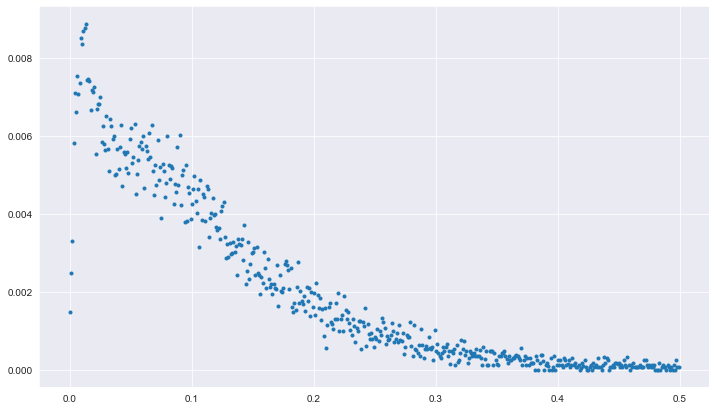

In [334]:
fig,ax = plt.subplots(figsize = (12,7))
a = np.array(hist)
x = a[:, 0]
y = a[:, 1]/np.sum(a[:,1])
plt.plot(x,y, '.')
plt.show()

This supposedly follows a gamma distribution, which takes the form

$$
p(x; \alpha, \beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-x/\beta}
$$

where 

$$
\Gamma(\alpha) = \int_0^\infty z^{\alpha - 1}e^{-z} dz
$$
and
$$\mathbb{E}[x] = \alpha \beta, \mathbb{E}[(x - \mathbb{E}[x])^2] = \alpha \beta^2$$

yet, we can see that the non-uniformity of the pixels in this area really distort the distribution that we expect to be approximated here: 

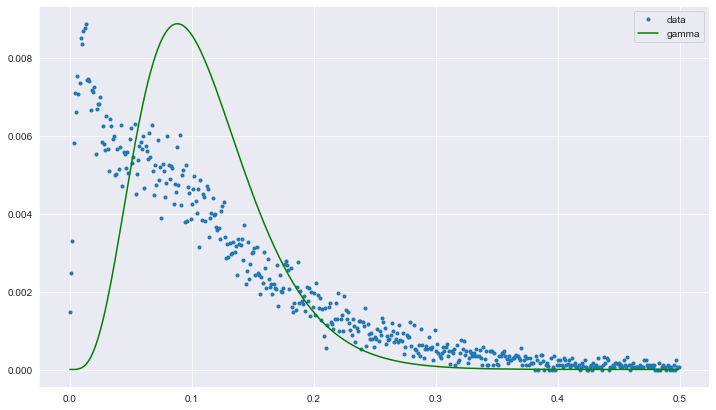

In [335]:
alpha = 5 # Playing around with this value shows different fits of the gamma distribution
beta = mean/alpha

fig, ax = plt.subplots(figsize=(12,7))
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-g', label='gamma') # Divide by 1000 since bucket widths of hist data are 0.001
plt.legend()
plt.show()

Let's look at a Sentinel-2 image of the the AOI to see the variation we're dealing with

In [336]:
im_s2 = ee.Image(sentinel_2.toList(sentinel_2.size()).get(1)).clip(aoi_sub)

In [337]:
im_s2.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12',
 'QA10',
 'QA20',
 'QA60']

In [338]:
time.strftime("%x", time.gmtime(im_s2.get('system:time_start').getInfo() / 1000))

'08/03/18'

In [339]:
loc_sub = aoi_sub.centroid().coordinates().getInfo()[::-1]

m = folium.Map(location=loc_sub, zoom_start=12)

m.add_ee_layer(im_s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'Bantaji')
m.add_child(folium.LayerControl())
display(m)

The cloud cover definitely obscures some of the imagery of the land cover, but we can tell that the land seems to be fairly heterogeneous.

Each of the pixel values in the Sentinel-1 band we've been using comes from a multi-look image, which are a sum/average of independent pixel value measurements. The intensity of each pixel value follows an exponential distribution, and the sum of *iid* exponential variables follows a gamma distribution. See [this page](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1) for a more detailed discussion. Based off of some consequences of the gamma distribution and the fact that the different looks are not independent, but correlated, the following value is equal to the *equivalent number of looks*

In [340]:
mean **2 / variance

1.296330467561212

## Part II: Hypothesis testing over two images

In [341]:
s1_im_coll = (sentinel_1_fl.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # Need local incidence angles to be the same in both images
                            .filter(ee.Filter.eq('relativeOrbitNumber_start', 59)) # One of two orbit numbers available
                            .sort('system:time_start')
)

In [342]:
acq_times = s1_im_coll.aggregate_array('system:time_start').getInfo()
times = [time.strftime('%x', time.gmtime(t/1000)) for t in acq_times]
print(times)

['08/01/18', '08/01/18', '08/13/18', '08/13/18', '08/25/18', '08/25/18', '09/06/18', '09/06/18', '09/18/18', '09/18/18', '09/30/18', '09/30/18', '10/12/18', '10/12/18', '10/24/18', '10/24/18']


Recall the flood start and end dates

In [343]:
flood_dates

[('2018-08-20', '2018-10-02')]

Select two images: one before and one after the incidence of the flood

In [344]:
date_ix_1 = times.index('08/13/18')
date_ix_2 = times.index('08/25/18')
im_list = s1_im_coll.toList(s1_im_coll.size())
im_1 = ee.Image(im_list.get(date_ix_1)).select('VV').clip(aoi_sub)
im_2 = ee.Image(im_list.get(date_ix_2)).select('VV').clip(aoi_sub)

In [345]:
ratio = im_1.divide(im_2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [346]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

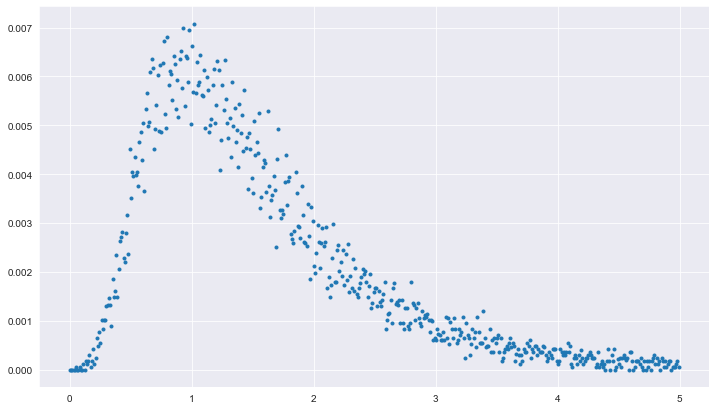

In [347]:
fig,ax = plt.subplots(figsize = (12,7))
a = np.array(hist)
x = a[:, 0]
y = a[:, 1]/np.sum(a[:,1])
plt.plot(x,y, '.')
plt.show()

This is actually an *F* distribution, which is defined as the ratio of two chi square distributions or gamma distributions, with $m_1 = 2m$ and $m_2 = 2m$, where $m$ is the degrees of freedom of the original variables. The mean and variance here are given by

$$
\mathbb{E}[x] = \frac{m}{m-1}\\
\mathbb{E}[(x - \mathbb{E}[x])^2] = \frac{m(2m-1)}{(m-1)^2(m-2)}
$$

Below we try to verify this empirically, although the data distribution looks right-skewed compared to the *F* distribution. This might be because the AOI we've pulled data from isn't texturally homogeneous.

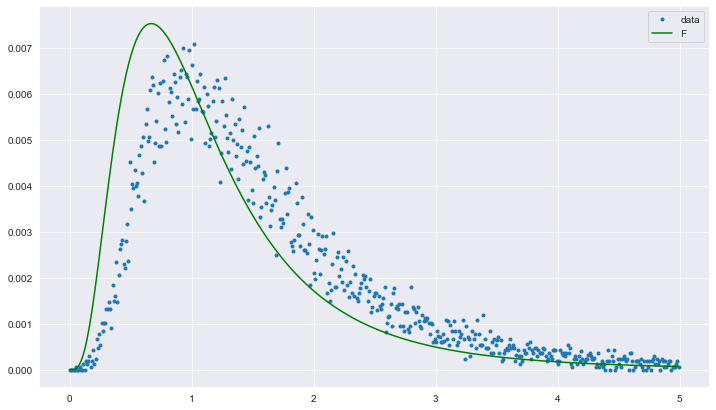

In [348]:
m = 5

fig, ax = plt.subplots(figsize = (12,7))
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m)/100, '-g', label='F')
plt.legend()
plt.show()

In [349]:
print(mean, m/(m-1))
print(variance, m*(2*m - 1)/(m-1)**2/(m-2))

1.6511852298771712 1.25
12.565964653845969 0.9375


In [350]:
mp = folium.Map(location=loc, zoome_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

We can perform a likelihood ratio test between pixels in the two images to determine whether or not there was a statistically significant change in SAR intensities. The intensity bands for the two multi-look images are supposedly distributed as 

$$
s \sim \text{Gamma}(\alpha = m, \beta = \frac{a}{m})\\
m = \text{number of looks}
$$

Therefore, the probability densities of the images follows as

$$
\mathbb{P}(s_i\ |\ a_i) = \frac{1}{(a_i / m)^m \Gamma(m)}s_i^{m-1}e^{-s_i m/a_i}
$$

The null and alternative hypotheses we wish to test are 

$$
\mathcal{H}_0 : a_1 = a_2 = a\\
\mathcal{H}_1 : a_1 \ne a_2
$$

The idea of the likelihood ratio test is to compare the ratio of the maximum likelihood of the data under the null hypothesis and the maximum likelihood of the data under the alternative hypothesis. To do so, we must calculate the maximum likelihood estimates for the variables we're testing under the two hypotheses: $a, a_1, a_2$.

Under the null hypothesis, the likelihood of getting the measured pixel intensities $s_1, s_2$ is 

$$
L_0(a) = \mathbb{P}(s_1|a)\mathbb{P}(s_2|a) = \frac{1}{(a/m)^2m \Gamma(m)^2}(s_1s_2)^{m-1}e^{-(s_1 + s_2)m/a}
$$

We can obtain the MLE $\hat a$ by finding the value where the derivative is equal to zero.

$$
\begin{aligned}
\frac{d L_0(a)}{da} = \frac{\bigg[(\frac{a}{m})^{2m} \Gamma(m)^2\bigg] (s_1s_2)^{m-1} \bigg(\frac{(s_1 +s_2)m}{a^2}\bigg)\exp\bigg(\frac{-(s_1 + s_2)m}{a} \bigg) - (s_1s_2)^{m-1} \exp \bigg(\frac{-(s_1 + s_2)m}{a}\bigg) \bigg[2a^{2m-1} \Gamma(m)^2\bigg] }{\bigg((\frac{a}{m})^4 \Gamma(m)^4 \bigg)} &= 0\\
(s_1s_2)^{m-1}\exp\bigg(\frac{-(s_1 + s_2)m}{a} \bigg) \Gamma(m)^2 \bigg[ \frac{a^{2m}(s_1 + s_2)m}{m^{2m}a^2} - \frac{2a^{2m-1}}{m^{2m-1}}\bigg] &= 0\\
\bigg[ \frac{a^{2m-2}(s_1 + s_2)}{m^{2m-1}} - \frac{2a^{2m-1}}{m^{2m-1}}\bigg] &= 0\\
a^{2m-2}(s_1 + s_2) &= 2a^{2m-1}\\
\frac{s_1 + s_2}{2} &= \hat a

\end{aligned}
$$

With this MLE, the maximum likelihood becomes:

$$
L_0(\hat a) = \frac{1}{((s_1 + s_2)/2m)^{2m}\Gamma(m)^2}(s_1s_2)^{m-1}e^{-2m}
$$

Similarly under the alternative hypothesis, the likelihood of getting the measured pixel intensities $s_1, s_2$ is 

$$
L_1(a_1, a_2) = \mathbb{P}(s_1|a_1)\mathbb{P}(s_2|a_2) = \frac{1}{(a_1/m)^m (a_2/m)^m \Gamma(m)^2}(s_1s_2)^{m-1}e^{-(s_1)m/a_1}e^{-(s_2)m/a_2}
$$

We can find the MLEs for $\hat a_1$ and $\hat a_2$ through the same method as before, where we'll find $\hat a_1 = s_1 \hat a_2 = s_2$. Therefore, the maxmimum likelihood under the alternative hypothesis is
$$
L_1(\hat a_1, \hat a_2) =  \frac{m^{2m}}{\Gamma(m)^2}(s_1s_2)e^{-2m}
$$

The ratio of these two maximum likelihoods becomes our test statistic $Q$:

$$
Q = \frac{L_0(\hat a)}{L_1(\hat a_1, \hat a_2)} = \bigg[2^2 \bigg( \frac{s_1 s_2}{(s_1 + s_2)^2} \bigg)\bigg]^m \le k
$$

This ratio can be simplified to one of

$$
\frac{s_1s_2}{(s_1 + s_2)^2} \le k' \ \ \ \text{or}\ \ \ \frac{(s_1 + s_2)^2}{s_1s_2} \ge k"\ \ \ \text{or}\ \ \ \frac{s_1}{s_2} + \frac{s_2}{s_1} \ge k" - 2
$$

where the last inequality is satisfied if either term is small enough:

$$
\frac{s_1}{s_2} < c_1\ \ \ \text{or}\ \ \ \frac{s_2}{s_1} < c_2
$$

Therefore we can use these terms as LRT statistics. $Q_1 = \frac{s_1}{s_2}$ can be used to test for a significant increase in intensity between time steps while $Q_2 = \frac{s_2}{s_1}$ can be used to test for a significant decrease in intensity. From before, the ratio of these two gamma variables follows an $F$ distribution.

In [379]:
alpha = .01
dt = f.ppf(alpha/2, 2*m, 2*m)

q1 = im_1.divide(im_2)
q2 = im_2.divide(im_1)

"""Here's a change map, where 0 = no change, 1 = decrease, 2 = increase in intensity"""
c_map = im_1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

"""Mask no-change pixels"""
c_map = c_map.updateMask(c_map.gt(0))

"""Display map with red for increase in intensity and blue for decrease in intensity"""
mp = folium.Map(location=loc_sub, zoom_start=13)

mp.add_ee_layer(im_s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'Bantaji Sentinel-2')
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')

mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']}, 'Change map')

mp.add_child(folium.LayerControl())

display(mp)

We can extend this analysis to use both the VV and VH bands of the Sentinel-1 imagery with a new LRT statistic that compares the maximum likelihoods of the product of four gamma distributions (one for each image times one for each band):

$$
Q = \frac{L_0(\hat a, \hat b)}{L_1(\hat a_1, \hat b_1, \hat a_2, \hat b_2)} = \frac{2^4 (s_1 r_1 s_2 r_2)^m}{(s_1 + s_2)^{2m}(r_1 + r_2)^{2m}}
$$

If we represent the bands $s$ and $r$ in the form of a covariance matrix $c$, we can rewrite this statistic in terms of the determinants of $c_i$:

$$
c_i = \begin{pmatrix}s_i & 0\\0 & r_i \end{pmatrix}
$$

$$
Q = \bigg[2^4 \bigg(\frac{|c_1| |c_2|}{|c_1 + c_2|^2} \bigg) \bigg]^m \le k
$$

According to Wilks' Theorem, $-2\log Q$ approaches a chi-square distribution with $d - d_0 = 2$ degrees of freedom.

$$
-2 \log Q = (\log|c_1| + \log |c_2| -2 \log |c_1 + c_2| + 4 \log 2)(-2m)
$$

We'll see below if this is the case

In [355]:
def det(im):
    return im.expression('b(0) * b(1)')

"""Number of looks"""
m = 5

im_1_bivariate = ee.Image(im_list.get(date_ix_1)).select('VV', 'VH').clip(aoi_sub)
im_2_bivariate = ee.Image(im_list.get(date_ix_2)).select('VV', 'VH').clip(aoi_sub)

m2logQ = det(im_1_bivariate).log().add(det(im_2_bivariate).log()).subtract(
    det(im_1_bivariate.add(im_2_bivariate)).log().multiply(2)
).add(4*np.log(2)).multiply(-2*m)

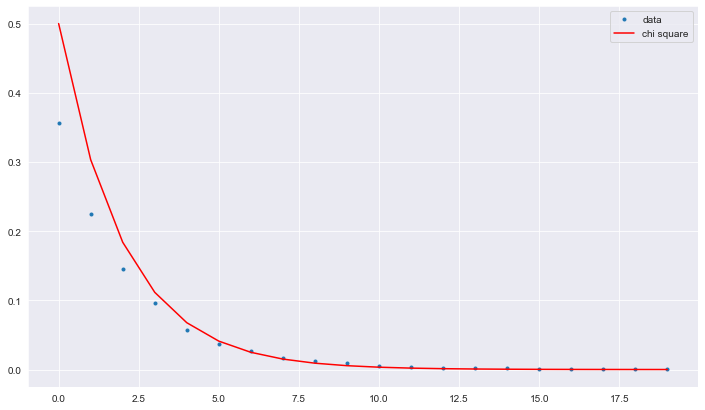

In [359]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 20), aoi_sub).get('VV').getInfo()

a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])

fig, ax = plt.subplots(figsize = (12,7))
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2), '-r', label='chi square')
plt.legend()
plt.show()

A decent fit, with some deviation probably due to the same texture issues as before. Let's plot the CDF of the chi-square distribution over the scene to visualize the p-values.

In [367]:
def chi2cdf(chi2, df):
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

p_value = ee.Image.constant(1).subtract(chi2cdf(m2logQ, 2))

c_map_bivariate = p_value.multiply(0).where(p_value.lt(0.01), 1)

mp = folium.Map(location=loc_sub, zoom_start = 13)
mp.add_ee_layer(im_s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'Bantaji Sentinel-2')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']}, 'Change map')
mp.add_ee_layer(p_value,
                {'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'p-value')
mp.add_ee_layer(c_map_bivariate.updateMask(
    c_map_bivariate.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'lightgreen']}, 'p_value < .01'
)
mp.add_child(folium.LayerControl())
display(mp)

Let's repeat this analysis quickly for another region nearby where flooding did not occur to see the difference

In [368]:
nigeria_aoi_no_flood = {
  "type": "FeatureCollection",
  "features": [
   {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              10.070343017578125,
              8.208941793684874
            ],
            [
              10.09592056274414,
              8.208941793684874
            ],
            [
              10.09592056274414,
              8.226951052987586
            ],
            [
              10.070343017578125,
              8.226951052987586
            ],
            [
              10.070343017578125,
              8.208941793684874
            ]
          ]
        ]
      }
    }
  ]
}
coords = nigeria_aoi_no_flood['features'][0]['geometry']['coordinates']
aoi_sub_no_flood = ee.Geometry.Polygon(coords)

In [378]:
im_s2_nf = ee.Image(sentinel_2.toList(sentinel_2.size()).get(7)).clip(aoi_sub_no_flood)

"""Univariate"""
im_1_nf = ee.Image(im_list.get(date_ix_1)).select('VV').clip(aoi_sub_no_flood)
im_2_nf = ee.Image(im_list.get(date_ix_2)).select('VV').clip(aoi_sub_no_flood)

alpha = .01
dt = f.ppf(alpha/2, 2*m, 2*m)

q1_nf = im_1_nf.divide(im_2_nf)
q2_nf = im_2_nf.divide(im_1_nf)

"""Here's a change map, where 0 = no change, 1 = decrease, 2 = increase in intensity"""
c_map_nf = im_1_nf.multiply(0).where(q2.lt(dt), 1)
c_map_nf = c_map_nf.where(q1.lt(dt), 2)

"""Mask no-change pixels"""
c_map_nf = c_map_nf.updateMask(c_map_nf.gt(0))

"""Bivariate"""

im_1_bivariate_nf = ee.Image(im_list.get(date_ix_1)).select('VV', 'VH').clip(aoi_sub_no_flood)
im_2_bivariate_nf = ee.Image(im_list.get(date_ix_2)).select('VV', 'VH').clip(aoi_sub_no_flood)

m2logQ_nf = det(im_1_bivariate_nf).log().add(det(im_2_bivariate_nf).log()).subtract(
    det(im_1_bivariate_nf.add(im_2_bivariate_nf)).log().multiply(2)
).add(4*np.log(2)).multiply(-2*m)

p_value_nf = ee.Image.constant(1).subtract(chi2cdf(m2logQ_nf, 2))

c_map_bivariate_nf = p_value_nf.multiply(0).where(p_value_nf.lt(0.01), 1)

"""Display map with both flooded and non-flooded regions"""
mp = folium.Map(location=loc_sub, zoom_start = 13)
mp.add_ee_layer(im_s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'Bantaji Sentinel-2 flood')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']}, 'Change map flood')
mp.add_ee_layer(p_value,
                {'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'p-value flood')
mp.add_ee_layer(c_map_bivariate.updateMask(
    c_map_bivariate.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'lightgreen']}, 'p_value < .01 flood'
)
mp.add_ee_layer(im_s2_nf, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'Bantaji Sentinel-2 no flood')
mp.add_ee_layer(c_map_nf,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']}, 'Change map no flood')
mp.add_ee_layer(p_value_nf,
                {'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'p-value no flood')
mp.add_ee_layer(c_map_bivariate_nf.updateMask(
    c_map_bivariate_nf.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'lightgreen']}, 'p_value < .01 no flood'
)
mp.add_child(folium.LayerControl())
display(mp)

In [377]:
sentinel_2.size()